## 6.01 - Supervised Learning Model Comparison

Recall the "data science process."

1. Define the problem.
2. Gather the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus mostly on creating (and then comparing) many regression and classification models. Thus, we'll define the problem and gather the data for you.
Most of the questions requiring a written response can be written in 2-3 sentences.

### Step 1: Define the problem.

You are a data scientist with a financial services company. Specifically, you want to leverage data in order to identify potential customers.

If you are unfamiliar with "401(k)s" or "IRAs," these are two types of retirement accounts. Very broadly speaking:
- You can put money for retirement into both of these accounts.
- The money in these accounts gets invested and hopefully has a lot more money in it when you retire.
- These are a little different from regular bank accounts in that there are certain tax benefits to these accounts. Also, employers frequently match money that you put into a 401k.
- If you want to learn more about them, check out [this site](https://www.nerdwallet.com/article/ira-vs-401k-retirement-accounts).

We will tackle one regression problem and one classification problem today.
- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.

Check out the data dictionary [here](http://fmwww.bc.edu/ec-p/data/wooldridge2k/401KSUBS.DES).

### NOTE: When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable. When predicting `e401k`, you may use the entire dataframe if you wish.

### Step 2: Gather the data.

##### 1. Read in the data from the repository.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import requests 
import re
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
data = pd.read_csv('401ksubs.csv')

In [2]:
data.head()

,e401k,inc,marr,male,age,fsize,nettfa,p401k,pira,incsq,agesq
0,0,13.170,0,0,40,1,4.575,0,1,173.4489,1600
1,1,61.230,0,1,35,1,154.000,1,0,3749.1130,1225
2,0,12.858,1,0,44,2,0.000,0,0,165.3282,1936
3,0,98.880,1,1,44,2,21.800,0,0,9777.2540,1936
4,0,22.614,0,0,53,1,18.450,0,0,511.3930,2809


##### 2. What are 2-3 other variables that, if available, would be helpful to have?

## Answer

> 1. Occupation
>
> 2. Where they live
>
> 3. Education

##### 3. Suppose a peer recommended putting `race` into your model in order to better predict who to target when advertising IRAs and 401(k)s. Why would this be an unethical decision?

## Answer

> I think by adding in race, you are including some pretty unethical biases regarding race, income and people class and trying to use that as a basis for who to target your advertising toward is in itsself unethical. If we can avoid adding in features that can include bias we're going to have a more ethical and accurate model.

** Also I think this is more of an opinion question and isn't (for lack of a better phrasing) a black and white issue. I'm still torn on my thoughts about this subject.

## Step 3: Explore the data.

##### 4. When attempting to predict income, which feature(s) would we reasonably not use? Why?

## Answer

> In general we would not use any features that would be considered unethical such as race, criminal records, actual identities, etc. For our data set I dont see any features to reasonably not use. If you made me pick one maybe married? 

In [3]:
data.shape

(9275, 11)

In [4]:
data.dtypes

e401k       int64
inc       float64
marr        int64
male        int64
age         int64
fsize       int64
nettfa    float64
p401k       int64
pira        int64
incsq     float64
agesq       int64
dtype: object

In [5]:
data.isnull().sum()

e401k     0
inc       0
marr      0
male      0
age       0
fsize     0
nettfa    0
p401k     0
pira      0
incsq     0
agesq     0
dtype: int64

In [6]:
data.describe()

,e401k,inc,marr,male,age,fsize,nettfa,p401k,pira,incsq,agesq
count,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000
mean,0.392129,39.254641,0.628571,0.204420,41.080216,2.885067,19.071675,0.276226,0.254340,2121.192483,1793.652722
std,0.488252,24.090002,0.483213,0.403299,10.299517,1.525835,63.963838,0.447154,0.435513,3001.469424,895.648841
min,0.000000,10.008000,0.000000,0.000000,25.000000,1.000000,-502.302000,0.000000,0.000000,100.160100,625.000000
25%,0.000000,21.660000,0.000000,0.000000,33.000000,2.000000,-0.500000,0.000000,0.000000,469.155600,1089.000000
50%,0.000000,33.288000,1.000000,0.000000,40.000000,3.000000,2.000000,0.000000,0.000000,1108.091000,1600.000000
75%,1.000000,50.160000,1.000000,0.000000,48.000000,4.000000,18.449500,1.000000,1.000000,2516.025500,2304.000000
max,1.000000,199.041000,1.000000,1.000000,64.000000,13.000000,1536.798000,1.000000,1.000000,39617.320000,4096.000000


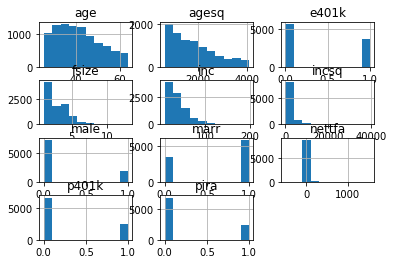

In [7]:
data.hist();

In [8]:
data.corr()

,e401k,inc,marr,male,age,fsize,nettfa,p401k,pira,incsq,agesq
e401k,1.000000,0.268178,0.080843,-0.027641,0.031526,0.012015,0.143950,0.769170,0.118643,0.206618,0.017526
inc,0.268178,1.000000,0.362008,-0.069871,0.105638,0.110170,0.376586,0.270833,0.364354,0.940161,0.087305
marr,0.080843,0.362008,1.000000,-0.363950,0.059047,0.564814,0.075039,0.085636,0.116925,0.280060,0.054500
male,-0.027641,-0.069871,-0.363950,1.000000,-0.120297,-0.320678,-0.018132,-0.024949,-0.036361,-0.053715,-0.116235
age,0.031526,0.105638,0.059047,-0.120297,1.000000,-0.030536,0.203906,0.025977,0.238557,0.097584,0.992619
fsize,0.012015,0.110170,0.564814,-0.320678,-0.030536,1.000000,-0.031506,0.014296,-0.043629,0.079570,-0.055924
nettfa,0.143950,0.376586,0.075039,-0.018132,0.203906,-0.031506,1.000000,0.187392,0.345917,0.407568,0.203703
p401k,0.769170,0.270833,0.085636,-0.024949,0.025977,0.014296,0.187392,1.000000,0.153033,0.222113,0.015740
pira,0.118643,0.364354,0.116925,-0.036361,0.238557,-0.043629,0.345917,0.153033,1.000000,0.322805,0.233543
incsq,0.206618,0.940161,0.280060,-0.053715,0.097584,0.079570,0.407568,0.222113,0.322805,1.000000,0.082991


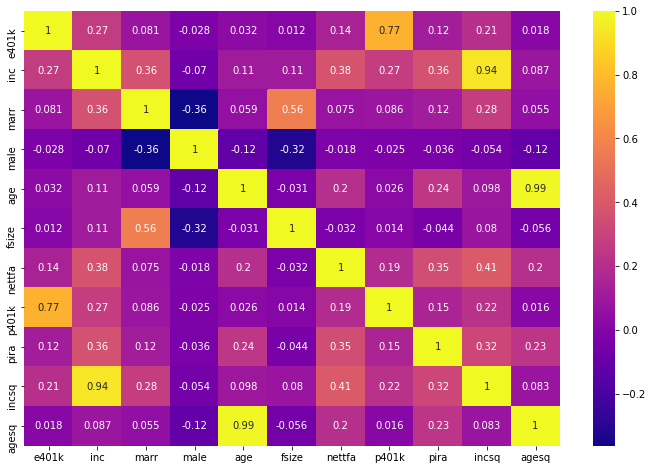

In [9]:
#Throwing our correlation into a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='plasma');

##### 5. What two variables have already been created for us through feature engineering? Come up with a hypothesis as to why subject-matter experts may have done this.
> This need not be a "statistical hypothesis." Just brainstorm why SMEs might have done this!

## Answer

> Age squared and income squared. The square, x to x², has a moderate effect on distribution shape and it could be used to reduce left skewness and make the distribution more normal

##### 6. Looking at the data dictionary, one variable description appears to be an error. What is this error, and what do you think the correct value would be?

## Answer

> I actually see quite a few errors. Age and income both have a description of age^2 and income^2. But i think maybe. Correct value should just be age and income?

## Step 4: Model the data. (Part 1: Regression Problem)

Recall:
- Problem: What features best predict one's income?
- When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable.

##### 7. List all modeling tactics we've learned that could be used to solve a regression problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific regression problem and explain why or why not.

## Answer

> Linear Regression, Logistic Regression, ridge, lasso, polinomial, KNN, gridsearch, Pipline, regularization, bootstrapping, bagging, decision tree, random forest, boosting, Naive Bayes.
>
>
> since our target variable is a continuous variable we need to use a regression model, so it's best for us to use Linear, ridge, lasso, polinomial


##### 8. Regardless of your answer to number 7, fit at least one of each of the following models to attempt to solve the regression problem above:
    - a multiple linear regression model
    - a k-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector regressor
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend setting a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

In [10]:
from sklearn.model_selection import train_test_split

X = data[['marr','male','fsize','nettfa','age','incsq','agesq']]
y = data['inc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print(f' Linear Regression Test Score is: {lr.score(X_test,y_test)}')

 Linear Regression Test Score is: 0.9063180467893468


In [13]:
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
knn_preds = knn.predict(X_test)
print(f' knn Test Score is: {knn.score(X_test,y_test)}')

 knn Test Score is: 0.9998003034495063


In [14]:
tree = DecisionTreeRegressor()
tree.fit(X_train,y_train)
tree_preds = tree.predict(X_test)
print(f' tree Test Score is: {tree.score(X_test,y_test)}')

 tree Test Score is: 0.99996764451647


In [15]:
bag = BaggingRegressor()
bag.fit(X_train,y_train)
bag_preds = bag.predict(X_test)
print(f' bag Test Score is: {bag.score(X_test,y_test)}')

 bag Test Score is: 0.9999793655913963


In [16]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
rfr_preds = rfr.predict(X_test)
print(f' rfr Test Score is: {rfr.score(X_test,y_test)}')

 rfr Test Score is: 0.9999876553499989


In [17]:
ada = AdaBoostRegressor()
ada.fit(X_train,y_train)
ada_preds = ada.predict(X_test)
print(f' ada Score is: {ada.score(X_test,y_test)}')

 ada Score is: 0.9903193855491527


In [18]:
svr = SVR()
svr.fit(X_train,y_train)
svr_preds = svr.predict(X_test)
print(f' SVR Test Score is: {svr.score(X_test,y_test)}')

 SVR Test Score is: 0.9539592592896977


##### 9. What is bootstrapping?

## Answer

> Bootstrapping is when we take a sample from our data and replace the values that we sampled

##### 10. What is the difference between a decision tree and a set of bagged decision trees? Be specific and precise!

## Answer

> A decision tree takes a dataset consisting of $X$ and $Y$ data, finds rules based on our $X$ data that partitions (splits) our data into smaller datasets such that by the bottom of the tree, the values $Y$ in each "leaf node" are as "pure" as possible.
>
> A bagged decision tree starts from the original data of size $n$, bootstrap $k$ samples each of size $n$ (with replacement!), builds a decision tree on each bootstrapped sample, then makea predictions by passing a test observation through all $k$ trees and developing one aggregate prediction for that observation.

##### 11. What is the difference between a set of bagged decision trees and a random forest? Be specific and precise!

## Answer

> With bagged decision trees, we generate many different trees on pretty similar data. These trees are strongly correlated with one another. Because these trees are correlated with one another, they will have high variance.
>
>Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each split in the learning process, a random subset of the features. 


##### 12. Why might a random forest be superior to a set of bagged decision trees?
> Hint: Consider the bias-variance tradeoff.

## Answer

> if one or a few features are very strong predictors for the response variable (target output), these features will be used in many/all of the bagged decision trees, causing them to become correlated. By selecting a random subset of features at each split, we counter this correlation between base trees, strengthening the overall model.

## Step 5: Evaluate the model. (Part 1: Regression Problem)

##### 13. Using RMSE, evaluate each of the models you fit on both the training and testing data.

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

RMSE_lr = sqrt(mean_squared_error(y_test, lr_preds))
print(f' Linear Regression RMSE is: {RMSE_lr}')

 Linear Regression RMSE is: 7.494823749270553


In [20]:
RMSE_knn = sqrt(mean_squared_error(y_test, knn_preds))
print(f' KNeighbors RMSE is: {RMSE_knn}')

 KNeighbors RMSE is: 0.34603397157007826


In [21]:
RMSE_tree = sqrt(mean_squared_error(y_test, tree_preds))
print(f' Decision Tree RMSE is: {RMSE_tree}')

 Decision Tree RMSE is: 0.13928597963483502


In [22]:
RMSE_bag = sqrt(mean_squared_error(y_test, bag_preds))
print(f' Bagged Decision trees RMSE is: {RMSE_bag}')

 Bagged Decision trees RMSE is: 0.11123192901328162


In [23]:
RMSE_rfr = sqrt(mean_squared_error(y_test, rfr_preds))
print(f' Random Forest RMSE is: {RMSE_rfr}')

 Random Forest RMSE is: 0.08603454107425343


In [24]:
RMSE_ada = sqrt(mean_squared_error(y_test, ada_preds))
print(f' Ada Boost RMSE is: {RMSE_ada}')

 Ada Boost RMSE is: 2.409266920490711


In [25]:
RMSE_svr = sqrt(mean_squared_error(y_test, svr_preds))
print(f' Support Vector RMSE is: {RMSE_svr}')

 Support Vector RMSE is: 5.254175885127685


##### 14. Based on training RMSE and testing RMSE, is there evidence of overfitting in any of your models? Which ones?

## Answer

> There is evidence of overfitting for our RandomForest, BaggingRegressor, and DecisionTreeRegressor models.Our KNN model as well just not as much

##### 15. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

## Answer

> Linear regression had the best score with the most reasonable RMSE, so that's what I would pick for my model

##### 16. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

## Answer

> Maybe do gridsearching and utilize Lasso and Ridge. Also maybe engineer more interaction features

## Step 4: Model the data. (Part 2: Classification Problem)

Recall:
- Problem: Predict whether or not one is eligible for a 401k.
- When predicting `e401k`, you may use the entire dataframe if you wish.

##### 17. While you're allowed to use every variable in your dataframe, mention at least one disadvantage of using `p401k` in your model.

## Answer

> If we're trying to predict whether or not someone is eligible for a 401k and we're using a column that mentions whther or not someone is elegibile for a 401k, this would overfit our model

##### 18. List all modeling tactics we've learned that could be used to solve a classification problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific classification problem and explain why or why not.

## Answer

> logistic regression, knn, decision tree, random forest, support vector, Naive Bayes

##### 19. Regardless of your answer to number 18, fit at least one of each of the following models to attempt to solve the classification problem above:
    - a logistic regression model
    - a k-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector classifier
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend using a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

In [26]:
X1 = data.drop('e401k', axis = 1)
y1 = data['e401k']

X_train, X_test, y_train, y_test = train_test_split(X1 ,y1, test_size=0.33, random_state=42)

In [27]:
lg = LogisticRegression()
lg.fit(X_train,y_train)
lg_preds = lg.predict(X_test)
print(f' Lg score is {lg.score(X_test,y_test)}')

 Lg score is 0.8853315909833388


C:\Users\CSAS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knn_preds = knn.predict(X_test)
print(f' KNN score is {knn.score(X_test,y_test)}')

 KNN score is 0.6213655668082326


In [29]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
tree_preds = tree.predict(X_test)
print(f' tree Test Score is: {tree.score(X_test,y_test)}')

 tree Test Score is: 0.8046390068605032


In [30]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)
bag_preds = bag.predict(X_test)
print(f' bag Test Score is: {bag.score(X_test,y_test)}')

 bag Test Score is: 0.8689970597843842


In [31]:
rfr = RandomForestClassifier()
rfr.fit(X_train,y_train)
rfr_preds = rfr.predict(X_test)
print(f' rfr Test Score is: {rfr.score(X_test,y_test)}')

 rfr Test Score is: 0.8781443972557987


In [32]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
ada_preds = ada.predict(X_test)
print(f' ada Score is: {ada.score(X_test,y_test)}')

 ada Score is: 0.8843515191114015


In [33]:
svc = SVC()
svc.fit(X_train,y_train)
svc_preds = svc.predict(X_test)
print(f' SVC Test Score is: {svc.score(X_test,y_test)}')

 SVC Test Score is: 0.655014701078079


## Step 5: Evaluate the model. (Part 2: Classfication Problem)

##### 20. Suppose our "positive" class is that someone is eligible for a 401(k). What are our false positives? What are our false negatives?

## Answer


> Our false positives are people determined to be eligible for 401(k) when they are not eligible.
>
> Our false negatives are people determined to not be eligible for 401(k) when they are eligible.

##### 21. In this specific case, would we rather minimize false positives or minimize false negatives? Defend your choice.

## Answer

>  We would rather minimize false negatives - We would not want to tell someone that they are ineligable for a 401k, thus having them not invest and miss out on potential earnings. 

##### 22. Suppose we wanted to optimize for the answer you provided in problem 21. Which metric would we optimize in this case?

## Answer

> Sensitivity/recall

##### 23. Suppose that instead of optimizing for the metric in problem 21, we wanted to balance our false positives and false negatives using `f1-score`. Why might [f1-score](https://en.wikipedia.org/wiki/F1_score) be an appropriate metric to use here?

## Answer

> The f1-score a metric of the balance between accuracy and precision. By using this score would should theoretically be able to find the best balance for our model

##### 24. Using f1-score, evaluate each of the models you fit on both the training and testing data.

In [34]:
from sklearn.metrics import f1_score

In [35]:
print(f' LG F1-Score is {f1_score(y_test, lg_preds)}')

 LG F1-Score is 0.8258064516129033


In [36]:
print(f' KNN F1-Score is {f1_score(y_test, knn_preds)}')

 KNN F1-Score is 0.47005029721079106


In [37]:
print(f' Tree F1-Score is {f1_score(y_test, tree_preds)}')

 Tree F1-Score is 0.7506255212677231


In [38]:
print(f' Bag F1-Score is {f1_score(y_test, bag_preds)}')

 Bag F1-Score is 0.809138505473584


In [39]:
print(f' RFR F1-Score is {f1_score(y_test, rfr_preds)}')

 RFR F1-Score is 0.817959980478282


In [40]:
print(f' ADA  F1-Score is {f1_score(y_test, ada_preds)}')

 ADA  F1-Score is 0.8247524752475247


In [41]:
print(f' SVC F1-Score is {f1_score(y_test, svc_preds)}')

 SVC F1-Score is 0.44537815126050423


##### 25. Based on training f1-score and testing f1-score, is there evidence of overfitting in any of your models? Which ones?

## Answer

> Possibly on BaggingRegressor, DecisionTreesRegressor, and RandomForestsRegressor.

##### 26. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

## Answer

> AdaBoost seems to have the strongest performance amoungst all the models.

##### 27. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

## Answer

> More features would might help the performance of the classifier. More data might be useful so maybe some additional bootstrapping would help as well.

## Step 6: Answer the problem.

##### BONUS: Briefly summarize your answers to the regression and classification problems. Be sure to include any limitations or hesitations in your answer.

- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.

# THE END